使用留一法 目标未进行 log 变换筛选的特征

In [1]:
# 数据加载与特征评分准备（Spearman + PLS）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cross_decomposition import PLSRegression

# 字体与符号设置，避免中文方块警告；如缺少字体会自动降级
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Noto Sans CJK SC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

TARGET_COL = 'lipid(%)'

df_standardized = pd.read_excel('../data/processed/data_standardized.xlsx')
feature_cols = df_standardized.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(TARGET_COL)

X_vals = df_standardized[feature_cols].values
y_vals = df_standardized[TARGET_COL].values

spearman_scores = {}
for i, col in enumerate(feature_cols):
    xi = X_vals[:, i]
    if np.isclose(np.std(xi), 0):
        spearman_scores[col] = 0.0
        continue
    rho, _ = stats.spearmanr(xi, y_vals, nan_policy='omit')
    spearman_scores[col] = 0.0 if np.isnan(rho) else abs(rho)

def calculate_vip(pls):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    s = np.sum(t**2, axis=0) * np.sum(q**2, axis=0)
    total_s = np.sum(s)
    if np.isclose(total_s, 0):
        return np.zeros(p)
    w_norm2 = (w / np.linalg.norm(w, axis=0))**2
    vip = np.sqrt(p * (w_norm2 @ s) / total_s)
    return vip

n_samples, n_features = X_vals.shape
pls = PLSRegression(n_components=min(3, n_samples - 1, n_features), scale=False)
pls.fit(X_vals, y_vals)
pls_scores = dict(zip(feature_cols, calculate_vip(pls)))

spearman_min, spearman_max = min(spearman_scores.values()), max(spearman_scores.values())
pls_min, pls_max = min(pls_scores.values()), max(pls_scores.values())

norm = lambda v, vmin, vmax: 0 if np.isclose(vmax - vmin, 0) else (v - vmin) / (vmax - vmin)

summary_df = pd.DataFrame({
    'feature': feature_cols,
    'Spearman_Raw': [spearman_scores[f] for f in feature_cols],
    'PLS_Raw': [pls_scores[f] for f in feature_cols]
})
summary_df['Spearman'] = summary_df['Spearman_Raw'].apply(lambda v: norm(v, spearman_min, spearman_max))
summary_df['PLS'] = summary_df['PLS_Raw'].apply(lambda v: norm(v, pls_min, pls_max))
summary_df['Average'] = summary_df[['Spearman', 'PLS']].mean(axis=1)
summary_df = summary_df.sort_values('Average', ascending=False).reset_index(drop=True)

print('Top 6 features (Spearman+PLS):', summary_df.head(6)['feature'].tolist())


Top 6 features (Spearman+PLS): ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']


Full features CV: transform    MAE   RMSE      R2
    raw y 4.0472 5.0528 -0.0956
 log1p(y) 3.5850 4.9125 -0.0356
Top-6 features CV: transform    MAE   RMSE     R2
    raw y 3.9052 4.8128 0.0060
 log1p(y) 3.3748 4.6055 0.0898


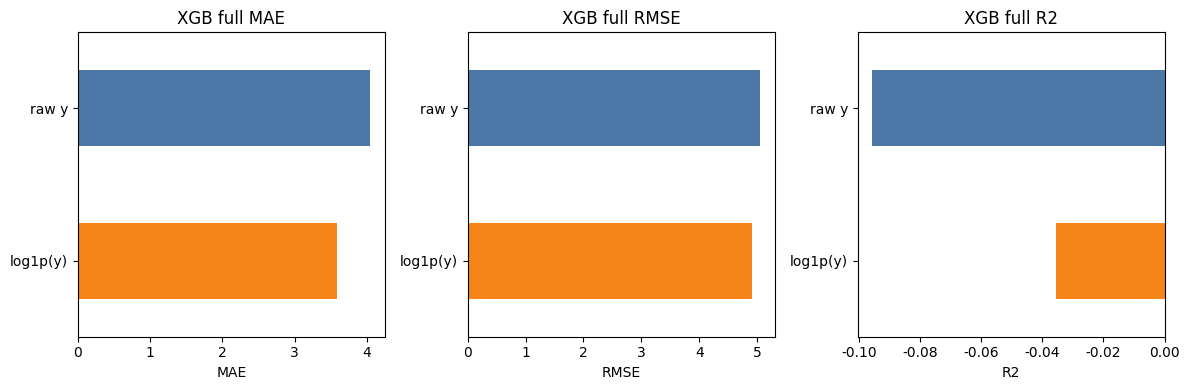

图已保存: ../results/xgb_full_repeated.png


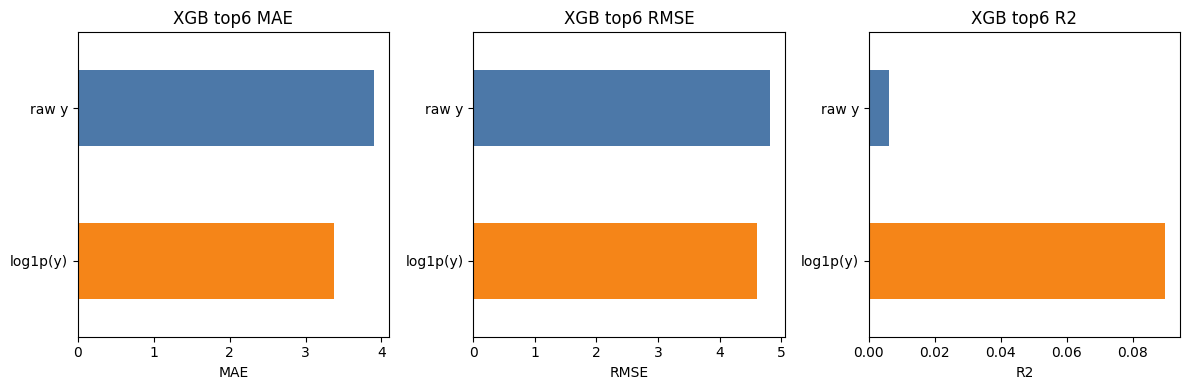

图已保存: ../results/xgb_subset_repeated.png
[GridSearch-MAE] full raw best MAE: 3.6202 params: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 400, 'reg_lambda': 1.0, 'subsample': 0.7}
[GridSearch-MAE] full log1p best MAE: 3.3708 params: {'regressor__colsample_bytree': 0.7, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 400, 'regressor__reg_lambda': 1.0, 'regressor__subsample': 0.7}
[GridSearch-MAE] top6 raw best MAE: 3.5983 params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 400, 'reg_lambda': 1.0, 'subsample': 0.9}
[GridSearch-MAE] top6 log1p best MAE: 3.1659 params: {'regressor__colsample_bytree': 0.7, 'regressor__gamma': 0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 2, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 400, 'regr

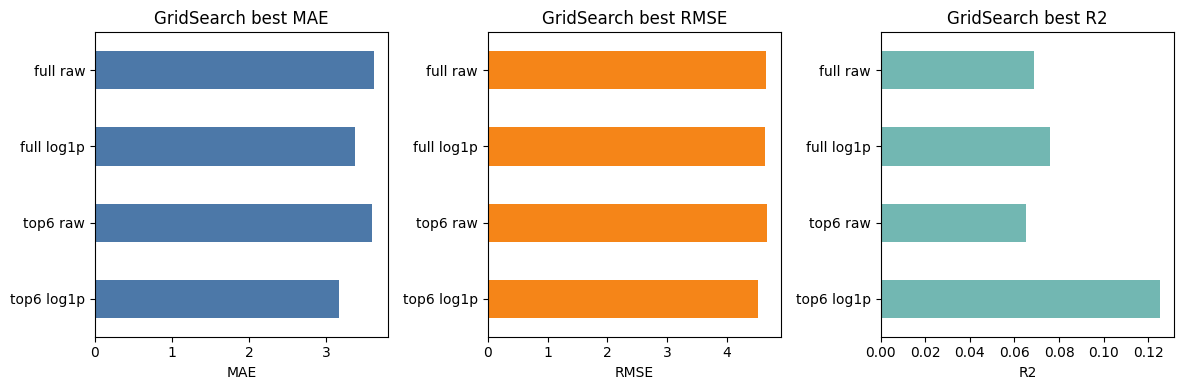

In [2]:
# XGBoost：全特征 & 前6特征 LOOCV + 网格搜索（MAE ， RMSE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Noto Sans CJK SC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

X_full = df_standardized.drop(columns=[TARGET_COL])
y_full = df_standardized[TARGET_COL]
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]

rkf = LeaveOneOut()
model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

def eval_cv(X, y):
    rows = []
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = XGBRegressor(**model_params)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        mae = mean_absolute_error(y_true_all, y_pred_all)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else 'raw y'
        rows.append({'transform': tag, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    return pd.DataFrame(rows)

res_full = eval_cv(X_full, y_full)
res_sub = eval_cv(X_sub, y_full)

print('Full features CV:', res_full.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print('Top-6 features CV:', res_sub.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

for title, df_res, fname in [
    ('XGB full', res_full, '../results/xgb_full_repeated.png'),
    ('XGB top6', res_sub, '../results/xgb_subset_repeated.png')
]:
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    for ax, metric, colors in zip(axes, ['MAE','RMSE','R2'], [['#4C78A8','#F58518']]*3):
        df_res.plot(kind='barh', x='transform', y=metric, ax=ax, color=colors, legend=False)
        ax.set_title(f'{title} {metric}')
        ax.set_ylabel('')
        ax.set_xlabel(metric)
        ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'图已保存: {fname}')

# 网格搜索（MAE 评分，LeaveOneOut）
grid_raw = {
    'max_depth': [2, 3],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 400],
    'reg_lambda': [1.0, 5.0]
}
base_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
rkf_gs = LeaveOneOut()

transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)
reg_log = TransformedTargetRegressor(regressor=base_reg, transformer=transformer)
grid_log = {f'regressor__{k}': v for k, v in grid_raw.items()}

# Fit four combinations
fitters = [
    ('full raw', base_reg, grid_raw, X_full, y_full, False),
    ('full log1p', reg_log, grid_log, X_full, y_full, True),
    ('top6 raw', base_reg, grid_raw, X_sub, y_full, False),
    ('top6 log1p', reg_log, grid_log, X_sub, y_full, True),
]

best_rows = []
for name, est, grid, Xc, yc, is_log in fitters:
    gs = GridSearchCV(estimator=est, param_grid=grid, cv=rkf_gs, scoring=scorer_mae, n_jobs=-1)
    gs.fit(Xc, yc)
    best_rows.append({
        'scenario': name,
        'best_MAE_cv': -gs.best_score_,
        'best_params': gs.best_params_,
        'best_estimator': gs.best_estimator_,
        'is_log': is_log,
        'X': Xc,
        'y': yc
    })
    print(f"[GridSearch-MAE] {name} best MAE: {-gs.best_score_:.4f} params: {gs.best_params_}")

# 最佳模型再评估（LeaveOneOut）
rkf_eval = LeaveOneOut()
rows_eval = []
for row in best_rows:
    name = row['scenario']
    est = row['best_estimator']
    Xc, yc = row['X'], row['y']
    preds, truths = [], []
    for train_idx, test_idx in rkf_eval.split(Xc):
        X_train, X_test = Xc.iloc[train_idx], Xc.iloc[test_idx]
        y_train, y_test = yc.iloc[train_idx], yc.iloc[test_idx]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    r2 = r2_score(y_true_all, y_pred_all)
    rows_eval.append({'scenario': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

eval_df = pd.DataFrame(rows_eval)
print('Best models re-evaluated (LOOCV):', eval_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# 绘制网格搜索最佳模型指标
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, metric, color in zip(axes, ['MAE','RMSE','R2'], ['#4C78A8','#F58518','#72B7B2']):
    eval_df.plot(kind='barh', x='scenario', y=metric, ax=ax, color=color, legend=False)
    ax.set_title(f'GridSearch best {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
    ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/xgb_gridsearch_best.png', dpi=300, bbox_inches='tight')
plt.show()


Full features CV:       model transform    MAE   RMSE      R2
       Ridge     raw y 4.5409 6.0448 -0.5680
       Ridge  log1p(y) 4.0465 5.3530 -0.2296
       Lasso     raw y 4.3245 4.9852 -0.0665
       Lasso  log1p(y) 4.0485 5.2294 -0.1735
  ElasticNet     raw y 4.6501 5.3956 -0.2493
  ElasticNet  log1p(y) 4.0485 5.2294 -0.1735
         PLS     raw y 5.9005 7.0589 -1.1382
         PLS  log1p(y) 5.1156 6.6295 -0.8860
RandomForest     raw y 4.3306 5.1925 -0.1570
RandomForest  log1p(y) 3.8156 5.1897 -0.1557


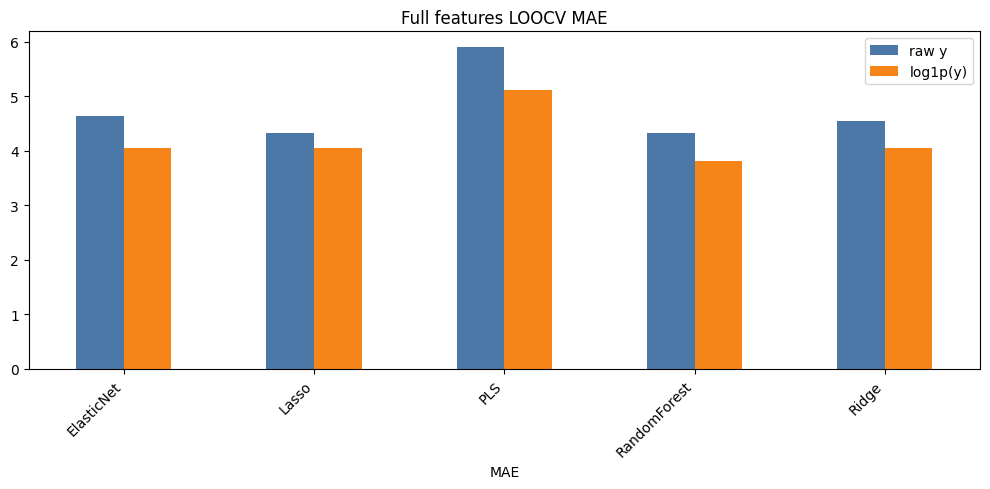

MAE figure saved: ../results/lin_pls_rf_full_mae.png


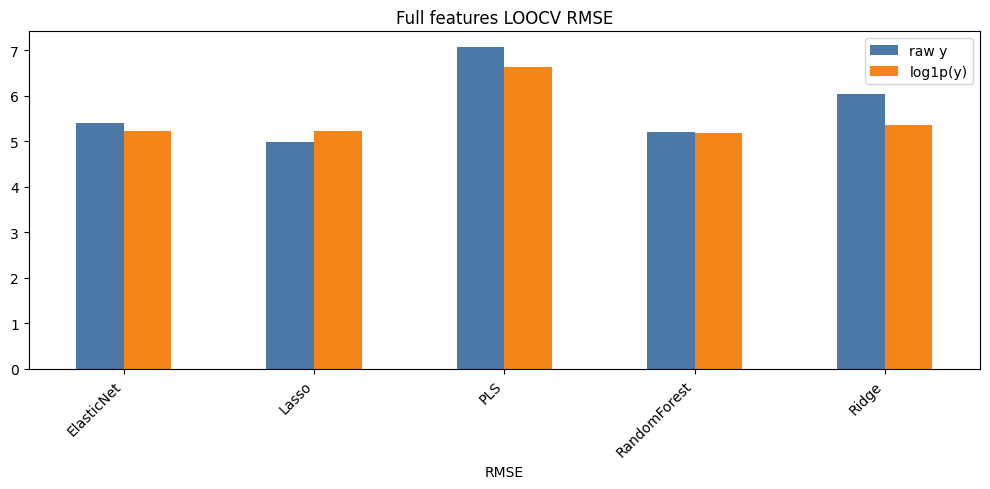

RMSE figure saved: ../results/lin_pls_rf_full_rmse.png


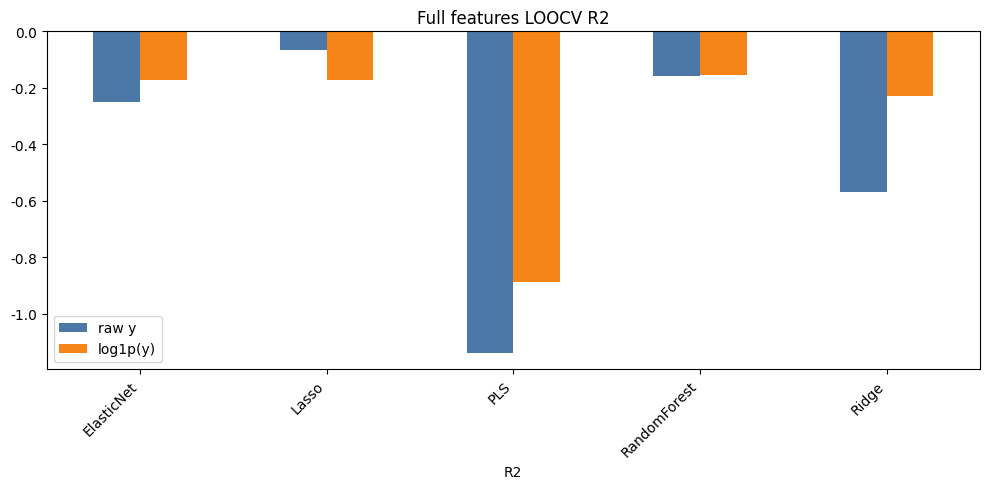

R2 figure saved: ../results/lin_pls_rf_full_r2.png
Top-6 features CV:       model transform    MAE   RMSE      R2
       Ridge     raw y 4.2523 5.1356 -0.1318
       Ridge  log1p(y) 3.8223 5.0644 -0.1006
       Lasso     raw y 4.3245 4.9852 -0.0665
       Lasso  log1p(y) 4.0485 5.2294 -0.1735
  ElasticNet     raw y 4.5745 5.3012 -0.2060
  ElasticNet  log1p(y) 4.0485 5.2294 -0.1735
         PLS     raw y 4.5514 5.5196 -0.3074
         PLS  log1p(y) 3.9387 5.2981 -0.2045
RandomForest     raw y 3.8838 4.7427  0.0348
RandomForest  log1p(y) 3.6507 4.9641 -0.0574


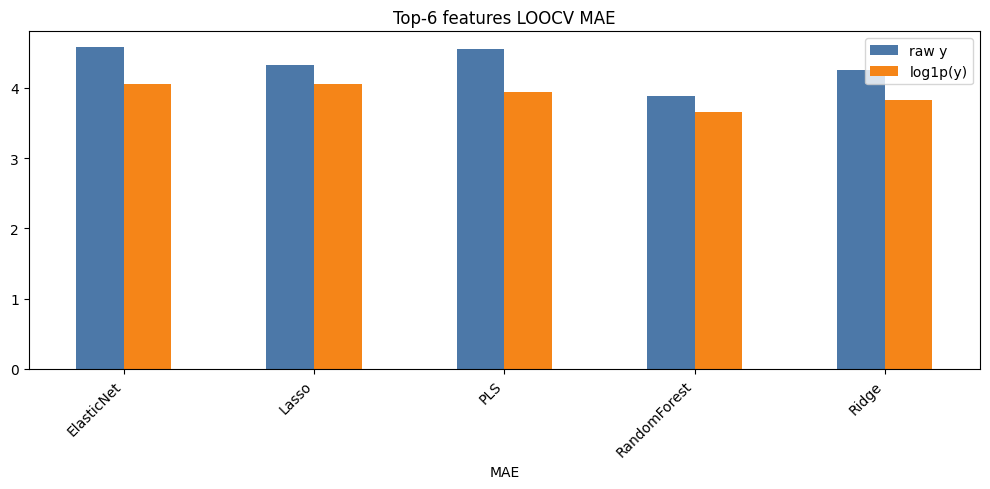

MAE figure saved: ../results/lin_pls_rf_sub_mae.png


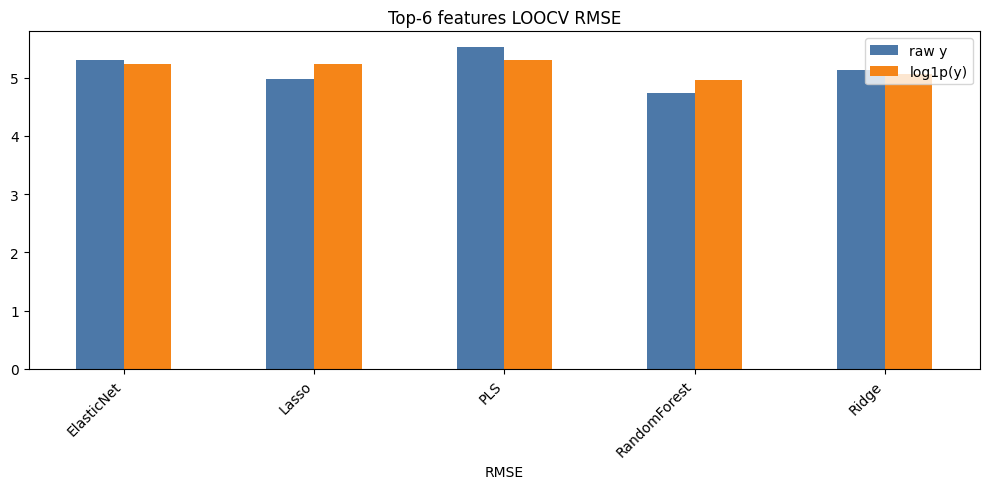

RMSE figure saved: ../results/lin_pls_rf_sub_rmse.png


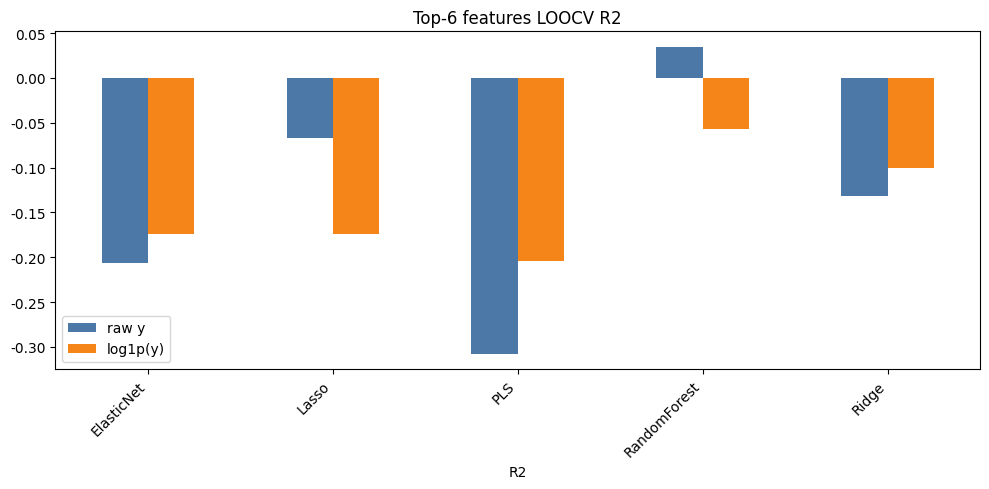

R2 figure saved: ../results/lin_pls_rf_sub_r2.png
Top-6 features: ['Turbidity', 'Total photosynthetic pigments', 'pH', 'DO', 'TOC', 'Dry cell weight']
[GridSearch-MAE] Ridge full raw best MAE: 4.2020, params: {'alpha': 0.01}
[GridSearch-MAE] Ridge full log1p best MAE: 3.8385, params: {'regressor__alpha': 0.1}
[GridSearch-MAE] Lasso full raw best MAE: 4.2074, params: {'alpha': 0.001, 'max_iter': 10000}
[GridSearch-MAE] Lasso full log1p best MAE: 3.9292, params: {'regressor__alpha': 0.001, 'regressor__max_iter': 10000}
[GridSearch-MAE] ElasticNet full raw best MAE: 4.2068, params: {'alpha': 0.001, 'l1_ratio': 0.8, 'max_iter': 10000}
[GridSearch-MAE] ElasticNet full log1p best MAE: 3.8974, params: {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.2, 'regressor__max_iter': 10000}
[GridSearch-MAE] PLS full raw best MAE: 5.4055, params: {'n_components': 1}
[GridSearch-MAE] PLS full log1p best MAE: 4.3119, params: {'regressor__n_components': 1}
[GridSearch-MAE] RandomForest full raw best M

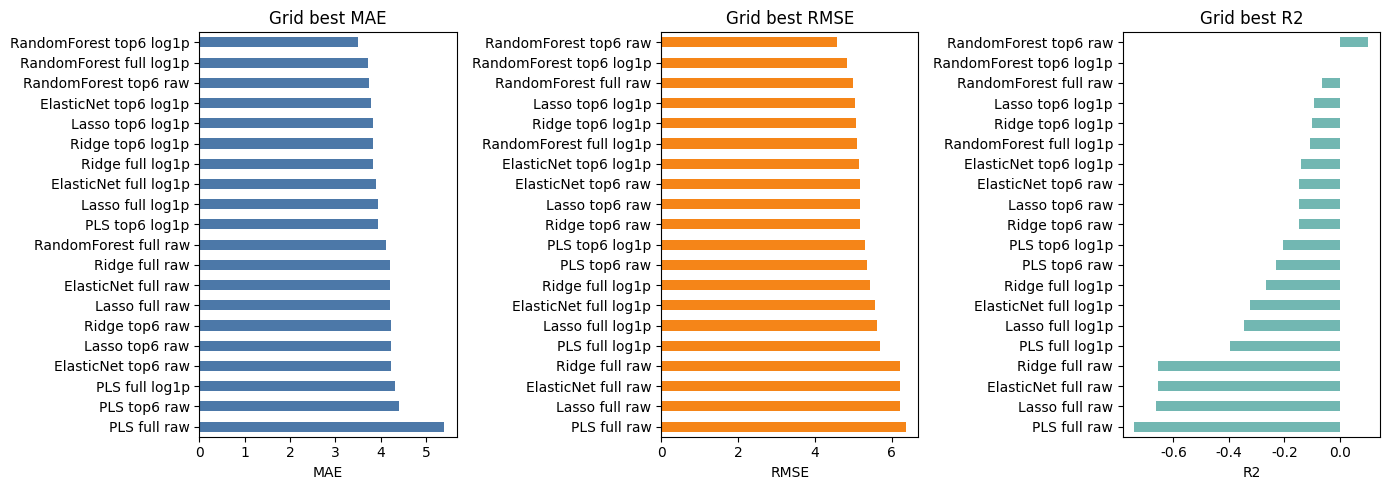

In [3]:
# Linear/PLS/RF: full & top6 LOOCV + grid search (MAE focus,  RMSE/R2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Noto Sans CJK SC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

X_full = df_standardized.drop(columns=[TARGET_COL])
y_full = df_standardized[TARGET_COL]
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]

models = {
    'Ridge': lambda _: Ridge(random_state=42),
    'Lasso': lambda _: Lasso(random_state=42, max_iter=10000),
    'ElasticNet': lambda _: ElasticNet(random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y_full) - 1), scale=False),
    'RandomForest': lambda _: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

rkf = LeaveOneOut()

# CV eval

def eval_cv(X, y):
    rows = []
    n_features = X.shape[1]
    for model_name, make_model in models.items():
        for transform in [False, True]:
            preds, truths = [], []
            for train_idx, test_idx in rkf.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                y_train_fit = np.log1p(y_train) if transform else y_train
                model = make_model(n_features)
                model.fit(X_train, y_train_fit)
                y_pred = model.predict(X_test)
                if transform:
                    y_pred = np.expm1(y_pred)
                preds.append(np.array(y_pred).ravel())
                truths.append(y_test.values)
            y_pred_all = np.concatenate(preds)
            y_true_all = np.concatenate(truths)
            mae = mean_absolute_error(y_true_all, y_pred_all)
            rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
            r2 = r2_score(y_true_all, y_pred_all)
            tag = 'log1p(y)' if transform else 'raw y'
            rows.append({'model': model_name, 'transform': tag, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    return pd.DataFrame(rows)

res_full = eval_cv(X_full, y_full)
res_sub = eval_cv(X_sub, y_full)

for title, df_res, prefix in [
    ('Full features', res_full, '../results/lin_pls_rf_full'),
    ('Top-6 features', res_sub, '../results/lin_pls_rf_sub')
]:
    print(f"{title} CV:" + df_res.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    for metric in ['MAE','RMSE','R2']:
        fig, ax = plt.subplots(figsize=(10,5))
        pivot = df_res.pivot(index='model', columns='transform', values=metric)
        col_order = [c for c in ['raw y', 'log1p(y)'] if c in pivot.columns]
        pivot = pivot[col_order]
        pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'][:len(col_order)], legend=True)
        ax.set_title(f'{title} LOOCV {metric}')
        ax.set_ylabel('')
        ax.set_xlabel(metric)
        ax.legend(labels=col_order, title='')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        img_path = f"{prefix}_{metric.lower()}.png"
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f'{metric} figure saved: {img_path}')
    if title.startswith('Top-6'):
        print('Top-6 features:', subset_features)

# Grid search (MAE scorer) with log1p option, LeaveOneOut
rkf_gs = LeaveOneOut()
scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)

param_grids = {
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1], 'max_iter': [10000]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1], 'l1_ratio': [0.2, 0.5, 0.8], 'max_iter': [10000]},
    'PLS': {'n_components': [1, 2, 3, 4]},
    'RandomForest': {'n_estimators': [200, 400], 'max_depth': [3, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 0.7]}
}

fit_configs = [
    ('full', X_full, y_full),
    ('top6', X_sub, y_full)
]

best_rows = []
for dataset_name, Xc, yc in fit_configs:
    n_features = Xc.shape[1]
    for model_name, grid in param_grids.items():
        base_est = models[model_name](n_features)
        # raw y
        gs_raw = GridSearchCV(base_est, param_grid=grid, cv=rkf_gs, scoring=scorer_mae, n_jobs=-1)
        gs_raw.fit(Xc, yc)
        best_rows.append({'scenario': f'{model_name} {dataset_name} raw', 'best_MAE_cv': -gs_raw.best_score_, 'best_params': gs_raw.best_params_, 'best_estimator': gs_raw.best_estimator_, 'X': Xc, 'y': yc})
        # log1p y
        transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=False)
        reg_log = TransformedTargetRegressor(regressor=base_est, transformer=transformer)
        grid_log = {f'regressor__{k}': v for k, v in grid.items()}
        gs_log = GridSearchCV(reg_log, param_grid=grid_log, cv=rkf_gs, scoring=scorer_mae, n_jobs=-1)
        gs_log.fit(Xc, yc)
        best_rows.append({'scenario': f'{model_name} {dataset_name} log1p', 'best_MAE_cv': -gs_log.best_score_, 'best_params': gs_log.best_params_, 'best_estimator': gs_log.best_estimator_, 'X': Xc, 'y': yc})
        print(f"[GridSearch-MAE] {model_name} {dataset_name} raw best MAE: {-gs_raw.best_score_:.4f}, params: {gs_raw.best_params_}")
        print(f"[GridSearch-MAE] {model_name} {dataset_name} log1p best MAE: {-gs_log.best_score_:.4f}, params: {gs_log.best_params_}")

# Re-evaluate best estimators for plotting
rkf_eval = LeaveOneOut()
eval_rows = []
for row in best_rows:
    est = row['best_estimator']
    Xc, yc = row['X'], row['y']
    preds, truths = [], []
    for train_idx, test_idx in rkf_eval.split(Xc):
        X_train, X_test = Xc.iloc[train_idx], Xc.iloc[test_idx]
        y_train, y_test = yc.iloc[train_idx], yc.iloc[test_idx]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    r2 = r2_score(y_true_all, y_pred_all)
    eval_rows.append({'scenario': row['scenario'], 'MAE': mae, 'RMSE': rmse, 'R2': r2})

eval_df = pd.DataFrame(eval_rows)
print('Best models (grid) re-eval LOOCV:', eval_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

fig, axes = plt.subplots(1, 3, figsize=(14,5))
for ax, metric, color in zip(axes, ['MAE','RMSE','R2'], ['#4C78A8','#F58518','#72B7B2']):
    eval_df.sort_values(metric, ascending=True if metric!='R2' else False).plot(kind='barh', x='scenario', y=metric, ax=ax, color=color, legend=False)
    ax.set_title(f'Grid best {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
    ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/lin_pls_rf_grid_best.png', dpi=300, bbox_inches='tight')
plt.show()
